In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt
from astroNN.nn.layers import MCDropout
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
from matplotlib.colors import LogNorm

In [2]:
ffnn = tf.keras.models.load_model('../models/FFNN_JLA2.h5') 
latent_dim = 1
decoder = tf.keras.models.load_model('../models/vaeffnn_decoder.h5', custom_objects={'latent_dim': latent_dim})
encoder = tf.keras.models.load_model('../models/vaeffnn_encoder.h5')
ffnn_do = tf.keras.models.load_model('../models/FFNN_JLA_DO.h5', custom_objects={'MCDropout': MCDropout})
#ffnn_do 2 and without 2


In [3]:
syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
file = '../data/jla_binned_distances_31nodes_v1.txt'

# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))
nsize = len(syscov)


data = np.loadtxt(file, skiprows=3)
z_redshift = data[:, 0]
dist = data[:,1]
errors = np.diag(syscov).reshape(nsize,)
errors_logs = np.where(errors!= 0, np.log(errors), 0)


-0.01084098704 0.02815552265 0.00039265133851975654


In [4]:
scalercov = StandardScaler()
scalercov.fit(syscov)
syscov_sc = scalercov.transform(syscov)

scalerdist = StandardScaler()
scalerdist.fit(data[:,1].reshape(-1,1))
dist_sc = scalerdist.transform(dist.reshape(nsize,1))

scalererr = StandardScaler()
scalererr.fit(errors.reshape(-1,1))
errors_sc = scalererr.transform(errors.reshape(nsize,1))

In [5]:
zseedlog = np.linspace(np.log10(0.01), np.log10(1.3), 31)
zpoints = 10**zseedlog
# zpoints = z_redshift
# zpoints = ranz+0.01*np.random.randn(31)
# orderMag(0.1)
# zpoints = zpoints+ 0.01*np.random.rand(31)
zpoints

array([0.01      , 0.01176156, 0.01383342, 0.01627025, 0.01913635,
       0.02250733, 0.02647212, 0.03113533, 0.03661999, 0.04307081,
       0.05065797, 0.05958166, 0.0700773 , 0.0824218 , 0.09694087,
       0.11401754, 0.13410237, 0.15772525, 0.18550944, 0.21818796,
       0.25662299, 0.30182857, 0.35499736, 0.41753213, 0.49108275,
       0.57758973, 0.67933539, 0.79900412, 0.93975316, 1.10529594,
       1.3       ])

In [6]:
ztest2 = encoder.predict(syscov.reshape((-1,31*31)))
z_mean_syscov, z_std_syscov, z_sample_syscov = ztest2
mean_ref = np.mean(dist)
std_ref = np.std(dist)
delta_mean = z_sample_syscov - mean_ref


In [7]:
pred_random = ffnn.predict(np.log10(zpoints))
# pred_random = ffnn.predict(zpoints)
dlfake = scalerdist.inverse_transform(pred_random.reshape(-1,1))
index = np.argsort(zpoints)
dlfake = dlfake.reshape(31,)[index]
zpoints = zpoints[index]
fake_data = np.stack((zpoints, dlfake), axis=1)

# np.savetxt("fake_binned_JLA_inter.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

In [8]:
mean_pred_interpoint = np.mean(dlfake)
std_pred_interpoint = np.std(dlfake)

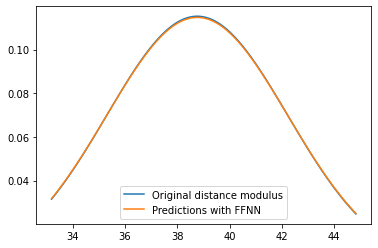

In [9]:
xmin = np.min(dlfake)
xmax= np.max(dlfake)
x = np.linspace(xmin, xmax, 100)
y1 = sp.stats.norm.pdf(x, mean_ref, std_ref)
y2 = sp.stats.norm.pdf(x, mean_pred_interpoint, std_pred_interpoint)

plt.plot(x, y1, label='Original distance modulus')
plt.plot(x, y2, label='Predictions with FFNN')

# plt.show()
# dist_sc
plt.legend()

Text(0.5, 1.0, 'From FFNN predictions')

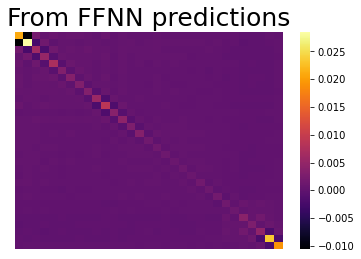

In [10]:
z_sample = np.array([mean_pred_interpoint+delta_mean])

newmatrix = decoder.predict(z_sample)
# newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31))
newmatrixr = newmatrix.reshape(31,31)
# newmatrixr = newmatrixr@D@newmatrixr.T
# # clean_imgr = clean_img[0,:,:,0].reshape(31,31)

# plt.figure(figsize=(9, 7), dpi=100)
# sns.set(font_scale=2)

sns.heatmap(pd.DataFrame(newmatrixr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False, cbar=True)

# np.savetxt("fake_binned_JLA_COVAE.dat", newmatrixr, delimiter= " ", header="#fake COV")
plt.title('From FFNN predictions',fontsize=25)
# plt.savefig('vae_cov_ffnn.png')

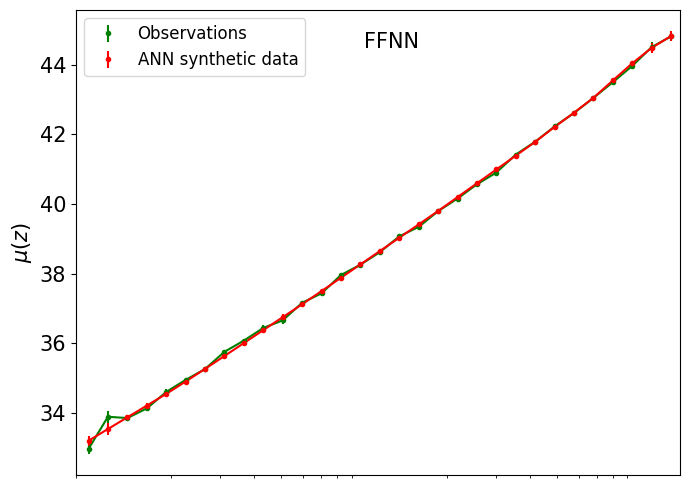

In [11]:
plt.figure(figsize=(7, 5), dpi=100)
# plt.scatter(z_redshift, dist,c='g', label='Observations')
# plt.scatter(zpoints, dlfake, c='r', label='Synthetic data', marker='*')
plt.errorbar(z_redshift, dist, yerr=np.sqrt(errors), c='g',  fmt='.', label='Observations')
plt.plot(z_redshift, dist, c='g')
plt.errorbar(zpoints, dlfake, yerr=np.sqrt(np.diag(newmatrixr)), c='r',  fmt='.', label='ANN synthetic data')
plt.plot(zpoints, dlfake, c='r')

plt.xscale('log')
# plt.xlabel([])
plt.ylabel("$\mu(z)$", fontsize=15)
# plt.xlim(-0.0, np.max(z_redshift)+0.1)
plt.xlim(0.009, 1.4)

plt.xticks([])
plt.text(0.1, 44.5, 'FFNN', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.legend(fontsize=12)

plt.savefig('JLA_FFNN_original.png')

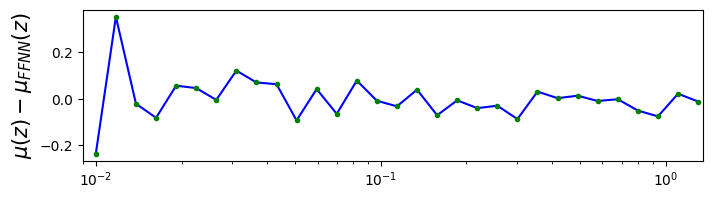

In [12]:
plt.figure(figsize=(8, 2), dpi=100)

mudiff = np.subtract(dist, dlfake.reshape(31,))
errdiff = np.subtract(np.sqrt(errors), np.sqrt(np.diag(newmatrixr)))
                                    
plt.errorbar(z_redshift, mudiff, yerr=errdiff, c='g',  fmt='.')
# plt.errorbar(zpoints, mudiff, yerr=np.sqrt(np.diag(newmatrixr)), c='r',  fmt='.')
plt.plot(z_redshift, mudiff, c='b')
plt.xlim(0.009, 1.35)
# plt.xlabel('Redshift $z$')
plt.xscale('log')

# plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel("$\mu(z) - \mu_{FFNN}(z)$", fontsize=15)
plt.savefig("Diferences_mod.png")

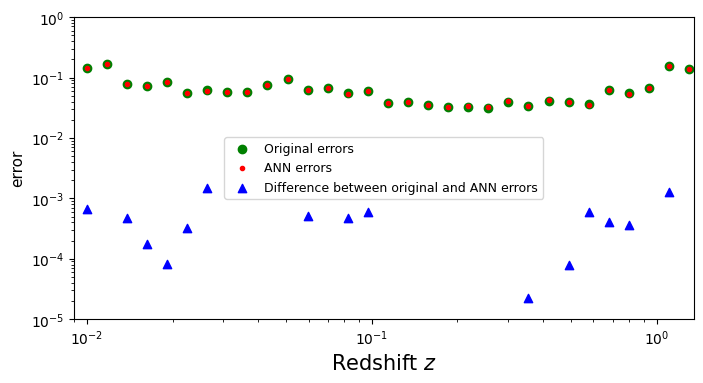

In [13]:
plt.figure(figsize=(8, 4), dpi=100)

mudiff = np.subtract(dist, dlfake.reshape(31,))
errdiff = np.subtract(np.sqrt(errors), np.sqrt(np.diag(newmatrixr)))
                                    
plt.scatter(z_redshift, np.sqrt(errors), c='g', marker='o', label='Original errors')
plt.scatter(zpoints, np.sqrt(np.diag(newmatrixr)), c='r', marker='.', label='ANN errors')
plt.scatter(z_redshift, errdiff, c='b', \
            marker='^', label="Difference between original and ANN errors" )
plt.xlim(0.009, 1.35)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5, 1)
plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel("error", fontsize=11)
plt.legend(fontsize=9, loc='center')
# plt.savefig('errors_original_redshifts.png')


In [14]:
Om = 0.23
# variance network
w0 = -1

# def RHSquared_a_lcdm(a):
# #         return Ezlcdm(a)**2
#     return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa):
#         if model == 'lcdm':
#             return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
#         elif model == 'owacdm':
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, w0=-1, wa=0.0):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, w0, wa)*(1+z))+43

zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
fowacdm1 = []
fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
    fowacdm1.append(distance_modulus(zzz, w0=-1.09, wa=0.3))
    fowacdm2.append(distance_modulus(zzz, w0=-1.04, wa=-0.3))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

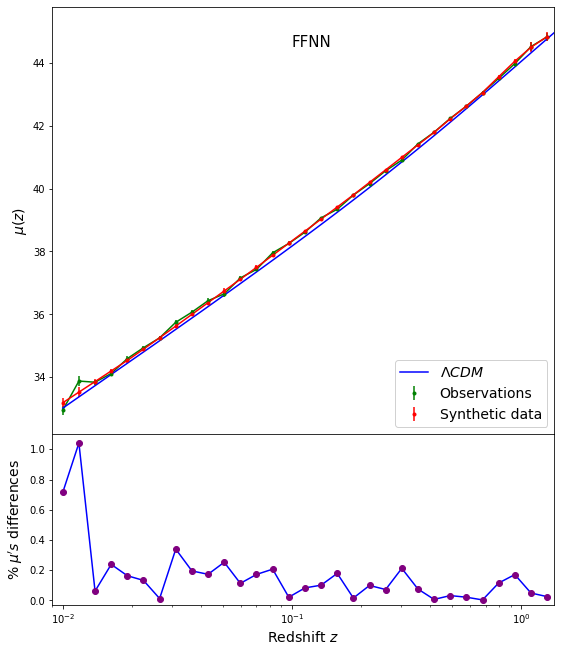

In [15]:
fig, axs = plt.subplots(2,1,figsize=(9, 11), gridspec_kw={'height_ratios': [5, 2]})

axs[0].errorbar(z_redshift, dist, yerr=np.sqrt(errors), c='g',  fmt='.', label='Observations')
axs[0].plot(z_redshift, dist, c='g')
axs[0].errorbar(zpoints, dlfake, yerr=np.sqrt(np.diag(newmatrixr)), c='r',  fmt='.', label='Synthetic data')
axs[0].plot(zpoints, dlfake, c='r')
axs[0].plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
# axs[0].plot(zmodel, fowacdm1, label='CPL $w_0 = -1.09, w_a=0.3', c='m')
axs[0].set_ylabel("$\mu(z)$", fontsize=14)
axs[0].set_xscale('log')
axs[0].set_xlim(0.009, 1.4)
axs[0].set_xticks([])
axs[0].text(0.1, 44.5, 'FFNN', fontsize=15)
axs[0].legend(fontsize=14, loc='lower right', framealpha=0.9, ncol=1)

                            

# plt.errorbar(zpoints, mudiff, yerr=np.sqrt(np.diag(newmatrixr)), c='r',  fmt='.')
axs[1].errorbar(z_redshift, 100*np.abs(mudiff/dist), yerr=errdiff, c='purple',  fmt='o')
# plt.errorbar(zpoints, mudiff, yerr=np.sqrt(np.diag(newmatrixr)), c='r',  fmt='.')
axs[1].plot(z_redshift, 100*np.abs(mudiff/dist), c='b')
axs[1].set_xlim(0.009, 1.4)
axs[1].set_ylim(-0.03, 1.1)
# axs[1].set_ylabel(r"$ \frac{\mu - \mu_{ANN}}{\mu}$", fontsize=14)
axs[1].set_ylabel("$\% \; \mu's$ differences", fontsize=14)
axs[1].set_xscale('log')



# axs[2].scatter(z_redshift, np.sqrt(errors), c='g', marker='o', label='Original errors')
# axs[2].scatter(zpoints, np.sqrt(np.diag(newmatrixr)), c='r', marker='.', label='ANN errors')
# axs[2].scatter(z_redshift, errdiff, c='b', \
#                 marker='^', label="Difference between original and ANN errors" )

# axs[2].set_xlim(0.009, 1.4)
# axs[2].set_xscale('log')
# axs[2].set_yscale('log')
# axs[2].set_ylim(1e-5, 1)
# axs[2].set_ylabel("error", fontsize=14)
# axs[2].legend(fontsize=10, loc='center', framealpha=1, ncol=3)

plt.subplots_adjust(wspace=0, hspace=0) 

plt.xlabel('Redshift $z$', fontsize=14)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# for a in axs:
#     a.set_xticklabels([])
#     a.set_yticklabels([])

plt.savefig('ffnn_jla.png')

# Now with MC-DO

In [16]:
pred_random = ffnn_do.predict(np.log10(zpoints))
dlfake_do = scalerdist.inverse_transform(pred_random[:,0].reshape(-1,1))
index = np.argsort(zpoints)
fake_data = np.stack((zpoints[index], dlfake_do.reshape(31,)[index]), axis=1)

# np.savetxt("fake_binned_JLADO_inter.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

<ipython-input-17-b3c551a876cc>:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(-0.0, np.max(z_redshift)+0.1)


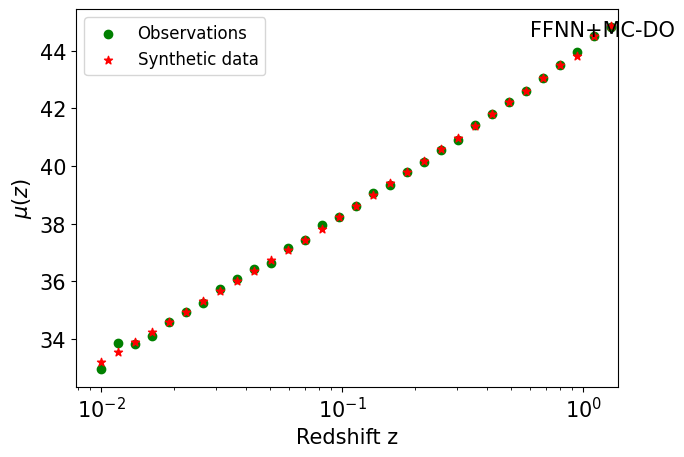

In [17]:
plt.figure(figsize=(7, 5), dpi=100)
plt.scatter(z_redshift, dist,c='g', label='Observations')
plt.scatter(zpoints, dlfake_do, c='r', label='Synthetic data', marker='*')

plt.xscale('log')
plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
plt.xlim(-0.0, np.max(z_redshift)+0.1)
plt.xticks(fontsize=15)
plt.text(0.6, 44.5, 'FFNN+MC-DO', fontsize=15)
plt.yticks(fontsize=15)
# plt.tight_layout()
plt.legend(fontsize=12)

In [18]:
mean_pred_interpoint_DO = np.mean(dlfake_do)
std_pred_interpoint_DO = np.std(dlfake_do)

Text(0.5, 0, 'Modulus distance $\\mu (z)$')

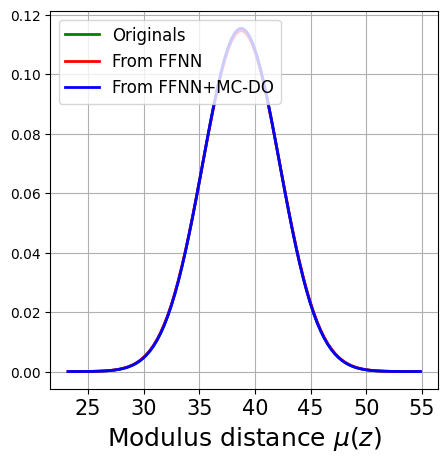

In [19]:
plt.figure(figsize=(5, 5), dpi=100, facecolor='white')
# plt.grid(b=None)

xmin = np.min(dlfake_do)
xmax= np.max(dlfake_do)
x = np.linspace(xmin-10, xmax+10, 100)
y1 = sp.stats.norm.pdf(x, mean_ref, std_ref)
y2 = sp.stats.norm.pdf(x, mean_pred_interpoint, std_pred_interpoint)
y3 = sp.stats.norm.pdf(x, mean_pred_interpoint_DO, std_pred_interpoint_DO)


plt.plot(x, y1, label='Originals', color='g', linewidth=2)
plt.plot(x, y2, label='From FFNN', color='r', linewidth=2)
plt.plot(x, y3, label='From FFNN+MC-DO', color='b', linewidth=2)

plt.grid(True)

# plt.hist(dist, density=True, alpha=0.3, color='g')
# plt.hist(dlfake, density=True, alpha=0.3, color='r')
# plt.hist(dlfake_do, density=True, alpha=0.3, color='b')
# plt.show()
# dist_sc
plt.legend(fontsize=12, loc='upper left')
# plt.yticks([])
plt.xticks(fontsize=15)

plt.xlabel("Modulus distance $\mu (z)$", fontsize=18)
# plt.savefig('modulus_dist_gauss.png', transparent=True)

In [20]:
# plt.figure(figsize=(7, 7), dpi=100)

# plt.hist(dist, density=True, alpha=0.3, color='g')
# plt.hist(dlfake, density=True, alpha=0.3, color='r')
# plt.hist(dlfake_do, density=True, alpha=0.3, color='b')
# # dist_sc
# plt.legend(fontsize=15)
# plt.yticks([])
# plt.xticks(fontsize=15)

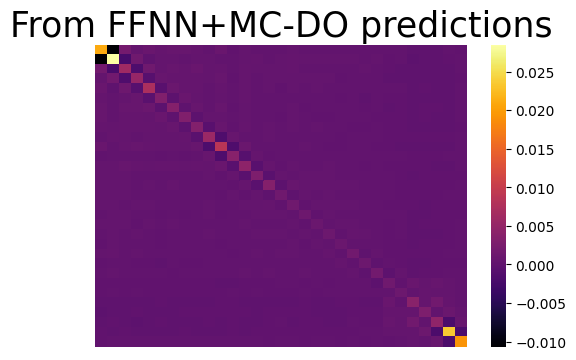

In [21]:
z_sample = np.array([mean_pred_interpoint_DO+delta_mean])

newmatrix_do = decoder.predict(z_sample)
# newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31))
newmatrixr_do = newmatrix_do.reshape(31,31)
# newmatrixr = newmatrixr@D@newmatrixr.T
# # clean_imgr = clean_img[0,:,:,0].reshape(31,31)


plt.figure(figsize=(6, 4), dpi=100)
# sns.set(font_scale=2)
sns.heatmap(newmatrixr_do, 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False, cbar=True)

# np.savetxt("fake_binned_JLA_COVAE_DO.dat", newmatrixr_do, delimiter= " ", header="#fake COV")
plt.title('From FFNN+MC-DO predictions', fontsize=25)
plt.savefig('vae_cov_ffnn_do.png')

Text(0, 0.5, '$\\mu(z) - \\mu_{FFNN}(z)$')

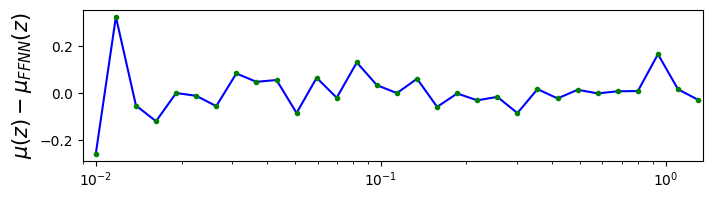

In [22]:
plt.figure(figsize=(8, 2), dpi=100)

mudiff_do = np.subtract(dist, dlfake_do.reshape(31,))
errdiff_do = np.subtract(np.sqrt(errors), np.sqrt(np.diag(newmatrixr_do)))
                                    
plt.errorbar(z_redshift, mudiff_do, yerr=errdiff, c='g',  fmt='.')
# plt.errorbar(zpoints, mudiff, yerr=np.sqrt(np.diag(newmatrixr)), c='r',  fmt='.')
plt.plot(z_redshift, mudiff_do, c='b')
plt.xlim(0.009, 1.35)

# plt.xlabel('Redshift $z$')
plt.xscale('log')

# plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel("$\mu(z) - \mu_{FFNN}(z)$", fontsize=15)
# plt.savefig("Diferences_mod.png")

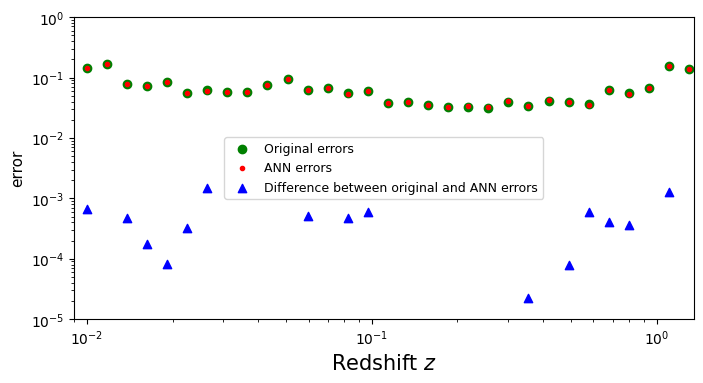

In [23]:
plt.figure(figsize=(8, 4), dpi=100)

mudiff_do = np.subtract(dist, dlfake_do.reshape(31,))
errdiff_do = np.subtract(np.sqrt(errors), np.sqrt(np.diag(newmatrixr_do)))
                                    
plt.scatter(z_redshift, np.sqrt(errors), c='g', marker='o', label='Original errors')
plt.scatter(zpoints, np.sqrt(np.diag(newmatrixr_do)), c='r', marker='.', label='ANN errors')
plt.scatter(z_redshift, errdiff_do, c='b', \
            marker='^', label="Difference between original and ANN errors" )
plt.xlim(0.009, 1.35)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5, 1)
plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel("error", fontsize=11)
plt.legend(fontsize=9, loc='center')

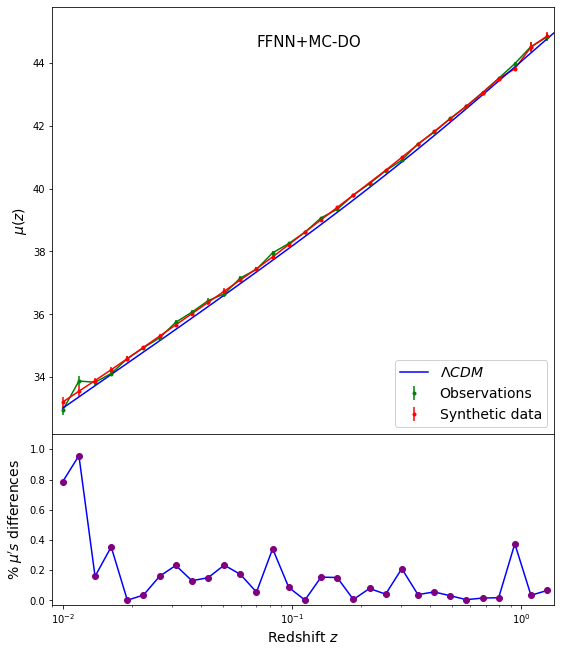

In [24]:
fig, axs = plt.subplots(2,1, figsize=(9, 11), gridspec_kw={'height_ratios': [5, 2]})

axs[0].errorbar(z_redshift, dist, yerr=np.sqrt(errors), c='g',  fmt='.', label='Observations')
axs[0].plot(z_redshift, dist, c='g')
axs[0].errorbar(zpoints, dlfake_do, yerr=np.sqrt(np.diag(newmatrixr_do)), c='r',  fmt='.', label='Synthetic data')
axs[0].plot(zpoints, dlfake_do, c='r')
axs[0].plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
# axs[0].plot(zmodel, fowacdm2, label='CPL $w_0 = -1.04, w_a=-0.3', c='m')
axs[0].set_ylabel("$\mu(z)$", fontsize=14)
axs[0].set_xscale('log')
axs[0].set_xlim(0.009, 1.4)
axs[0].set_xticks([])
axs[0].text(0.07, 44.5, 'FFNN+MC-DO', fontsize=15)
axs[0].legend(fontsize=14, loc='lower right', framealpha=0.9, ncol=1)

                            
axs[1].errorbar(z_redshift, 100*np.abs(mudiff_do/dist), yerr=errdiff_do, c='purple',  fmt='o')
axs[1].plot(z_redshift, 100*np.abs(mudiff_do/dist), c='b')
axs[1].set_xlim(0.009, 1.4)
axs[1].set_ylim(-0.03, 1.1)
axs[1].set_ylabel("$\% \; \mu's$ differences", fontsize=14)
axs[1].set_xscale('log')



# axs[2].scatter(z_redshift, np.sqrt(errors), c='g', marker='o', label='Original errors')
# axs[2].scatter(zpoints, np.sqrt(np.diag(newmatrixr_do)), c='r', marker='.', label='ANN errors')
# axs[2].scatter(z_redshift, errdiff_do, c='b', \
#                 marker='^', label="Difference between original and ANN errors" )

# axs[2].set_xlim(0.009, 1.4)
# axs[2].set_xscale('log')
# axs[2].set_yscale('log')
# axs[2].set_ylim(1e-5, 1)
# axs[2].set_ylabel("error", fontsize=14)
# axs[2].legend(fontsize=10, loc='center', framealpha=1, ncol=3)

plt.subplots_adjust(wspace=0, hspace=0) 

plt.xlabel('Redshift $z$', fontsize=14)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# for a in axs:
#     a.set_xticklabels([])
#     a.set_yticklabels([])

plt.savefig('ffnn_jla_do.png')

In [25]:
# plt.hist(dist, alpha=0.4)
# plt.hist(dlfake, alpha=0.4)
# plt.hist(dlfake_do, alpha=0.4)


/home/cosmocicatais/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/cosmocicatais/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/cosmocicatais/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

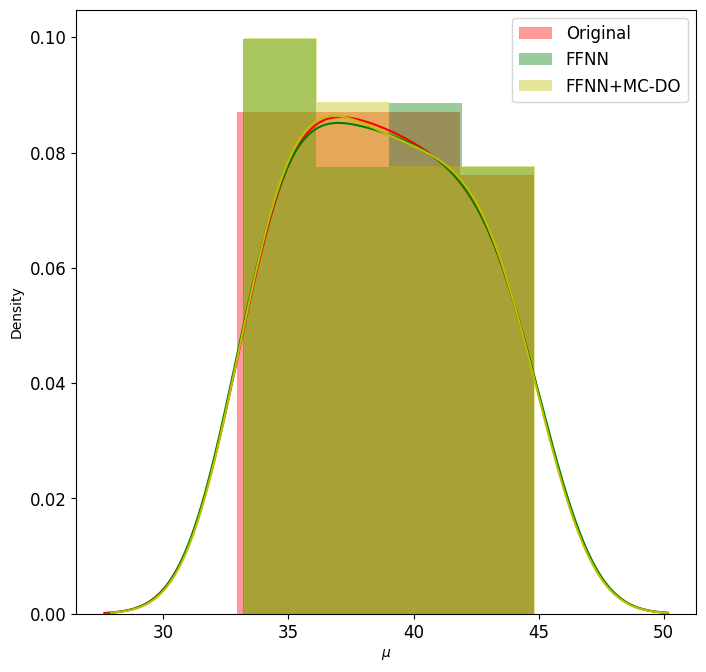

In [26]:
plt.figure(figsize=(8, 8), dpi=100)

sns.distplot(dist, color='r', label='Original')
sns.distplot(dlfake, color='g', label='FFNN')
sns.distplot(dlfake_do, color='y', label='FFNN+MC-DO')
plt.xlabel('$\mu$')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='upper right', fontsize=12)

<AxesSubplot:>

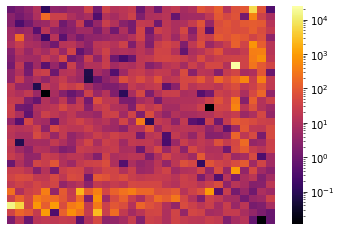

In [27]:
perc_matrix = 100*np.abs((syscov - newmatrixr_do)/ syscov)
sns.heatmap(perc_matrix, 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False, cbar=True, norm=LogNorm() )

In [28]:
z_sample = np.array([mean_ref+delta_mean])

newmatrix_ref = decoder.predict(z_sample)
# newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31))
newmatrixr_ref = newmatrix_ref.reshape(31,31)

<AxesSubplot:>

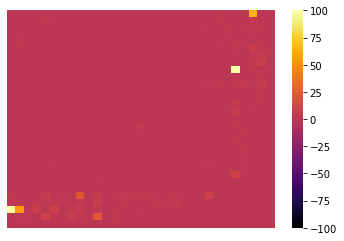

In [43]:
perc_matrix =np.abs((syscov - newmatrixr_ref)/ syscov)

sns.heatmap(perc_matrix, 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False, cbar=True, vmax=100, vmin=-100)

In [44]:
np.max(perc_matrix)

244.04668264437373

In [31]:
( perc_matrix > 10).sum()

8

In [32]:
( perc_matrix > 5).sum()

16

In [33]:
( perc_matrix > 1).sum()

74

In [40]:
( perc_matrix < 1).sum()

887